# Import libraries

Our data analysis is dependent on the following packages:
- [pandas](https://pandas.pydata.org/) for data manipulation
- [PyEnsembl](https://github.com/openvax/pyensembl) for working with genome data
- [seaborn](https://seaborn.pydata.org/) for drawing attractive statistical graphs
- [Matplotlib](https://matplotlib.org/) for visualizing data relationships
- [methylcheck](https://pypi.org/project/methylcheck/) for the density plot (they do it nice)
- [methylprep](https://pypi.org/project/methylprep/) to use methylcheck
- [umap-learn](https://pypi.org/project/umap-learn/) for building UMAPs
- [scikit-learn](https://scikit-learn.org/stable/index.html) for machine learning


You can install these modules by running the below script inside Jupyter:
```
%pip install pandas
%pip install pyensembl
%pip install seaborn
%pip install methylcheck
%pip install methylprep
%pip install umap-learn
%pip install scikit-learn
```

In [75]:
from pyensembl import EnsemblRelease
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import methylcheck
import pickle
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Change Ensembl IDs to HGNC

In [ ]:
# Open counts file
df = pd.read_pickle('../Data/Raw/BCCA_Counts.pickle')    

# Open clinical data
clinical_data = pd.read_pickle("../Data/clinical_data.pickle")

In [ ]:
clinical_data

## Gather meta data of all identified genes

In [ ]:
# Reference genome = GRCh38
# 9,033 Ensembl IDs were not identified
# 11,309 Ensembl IDs were identified but have no Gene ID (for the reference genome GRCh38)
    # These 11,309 were included in meta_data.pickle (gene_meta_data dataframe)

# Using pyensembl to get Ensembl Gene IDs
Genome = EnsemblRelease()
gene = Genome.gene_by_id(df.index[0])
gene_meta_data = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()

# Getting all the genes in the count file
unnamed_genes = []
for id, ensembl in enumerate(df.index):
    try:

        if id == 0:
            continue
        
        gene = Genome.gene_by_id(ensembl)

        temp_list = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()
        gene_meta_data = gene_meta_data.append(temp_list)

    except:
        unnamed_genes.append(ensembl)

# Making it pretty
gene_meta_data = gene_meta_data.rename(columns={0:'Gene_ID', 1:'Gene_Name', 2:'Gene_Biotype', 3:'Contig_Chromosome', 4:'Start', 5:'End', 6:'Strand'})
gene_meta_data = gene_meta_data.set_index("Gene_ID")

## Dropping nameless genes from dataframe

In [ ]:
identified_nameless_genes = []

for id, ensembl in enumerate(df.index):
    try:
        gene = Genome.gene_by_id(ensembl)

        if gene.gene_name == "":
            identified_nameless_genes.append(ensembl)
            continue
    except:
        continue

# Dropping the genes that have info about them, but no name (interesting ones)
gene_meta_data2 = gene_meta_data.drop(identified_nameless_genes)

# Gathering only the name of the genes (instead of the metadata (where can we find them, chr, etc.))
gene_names_column = gene_meta_data2["Gene_Name"]

# Dropping unnamed genes
df2 = df.drop(unnamed_genes)

# Finally making the HGNC genes in the index (where Ensembl lied)
df2 = df2.join(gene_names_column.to_frame()).set_index("Gene_Name")

# Log Scale the data

In [ ]:
df2 = np.log2(df2 + 1)
description_log_scaled_dataset = df2.T.describe().T

# Adjusting for non-expressed genes (37,688 in total)
HGNC_Log_Scaled = df2[description_log_scaled_dataset["std"] > 0]

# Creating a final, cleaned data frame

In [ ]:
# Gather Log-Scaled data
df0 = HGNC_Log_Scaled.T.reset_index()
df1 = df0.join(df0['index'].str.rsplit(pat='-',n=2,expand=True)[0])
df2 = df1.set_index(0)

# Change index of clinical data, then drop duplicates
clinical_data = clinical_data.rename(columns={"TARGET USI":"Patient_ID"}).set_index("Patient_ID")
clinical_data2 = clinical_data.reset_index().drop_duplicates(subset='Patient_ID').set_index('Patient_ID')

# Join Log-Scale and Clinical Data
df3 = df2.join(clinical_data2, how='inner')

df4 = df3.set_index("index")

# Only protocol/cohort we are going to use because it has >1000 samples and cohorts are not batch-corrected
df5 = df4[df4["Protocol"] == "AAML1031"]

# Get clinical data from the dataframe
df5_clinical  = df5.iloc[:,df3.shape[1]-clinical_data2.shape[1]-1:]

# Get the data from the dataframe
x = df5.iloc[:,:df3.shape[1]-clinical_data2.shape[1]-2]

# Export

In [ ]:
# Clinical Data
clinical_data.to_pickle("../Data/pickled/clinical_data.pickle")

# Processed Data
x.to_pickle("../Data/pickled/log_scaled_data.pickle")

# Gene meta data (where it lies, which chromosome, what it does, etc)
gene_meta_data.to_pickle('../Data/Pre_Processed/meta_data.pickle')

# Genes with no HGNC
unnamed_genes.to_pickle('../Data/Pre_Processed/unnamed_genes.pickle')

# Plotting

## Load stuff

In [73]:
log_scaled_data = pd.read_pickle('../Data/log_scaled_data.pickle')
clinical = pd.read_pickle('../Data/clinical_data.pickle')

## Density plot

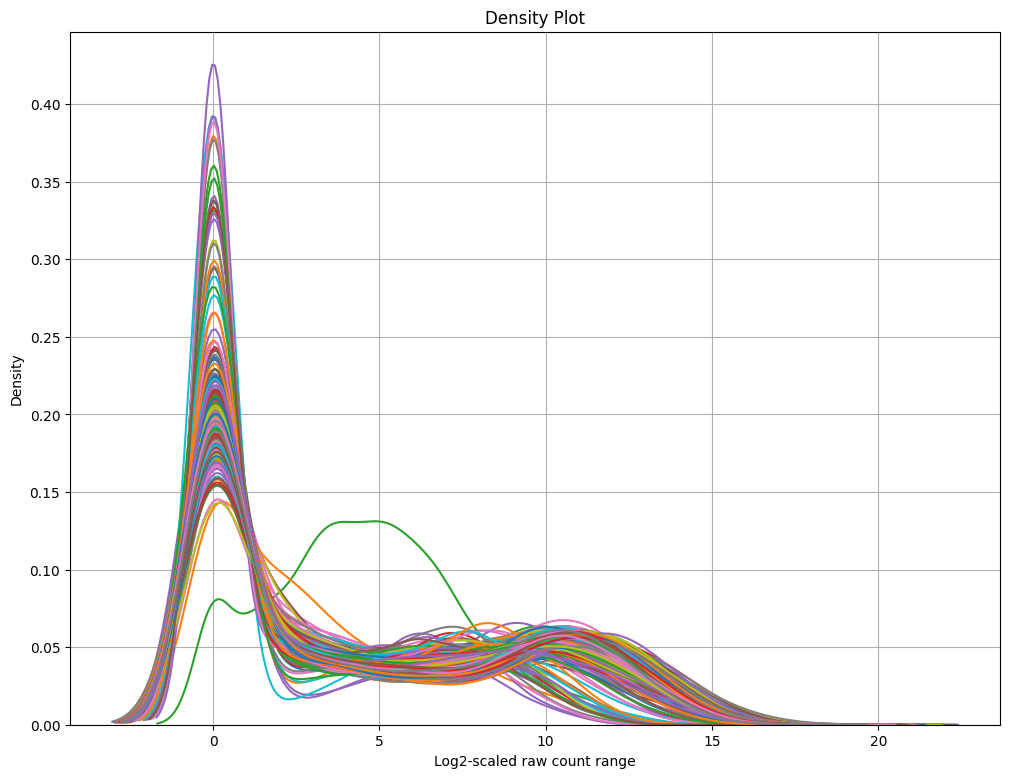

In [76]:
# TODO Find size of expression matrix, identify degree of variation; basically analyze this chart below
methylcheck.beta_density_plot(log_scaled_data, full_range=True, plot_title="Density Plot")

## PCA

In [83]:
# Fit PCA
pca_decomp = PCA(random_state=42, n_components=2)
data_PCs = pca_decomp.fit_transform(log_scaled_data.T)

In [93]:
def draw_PCAplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Define scatterplot

    sns.scatterplot(x=xs * scalex, y=ys * scaley,
                    palette='husl', s=10,
                    linewidth=0, alpha=1,
                    data=clinical, hue=hue)

    # Define plot specs
    plt.title("PCA Decomposition by RNA-seq, N=1038",
               fontsize = 12)        
               
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.tight_layout()

    # Save figure
    if(hue):
        title = hue
        plt.savefig('../Plots/PCA_by_' + title + '.png',
        bbox_inches='tight', dpi=300)
    else:
        plt.savefig('../Plots/PCA.png',
        bbox_inches='tight', dpi=300)

    return(plt.show())

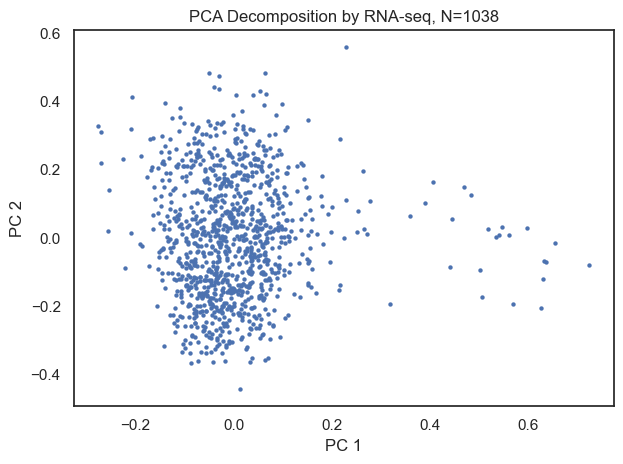

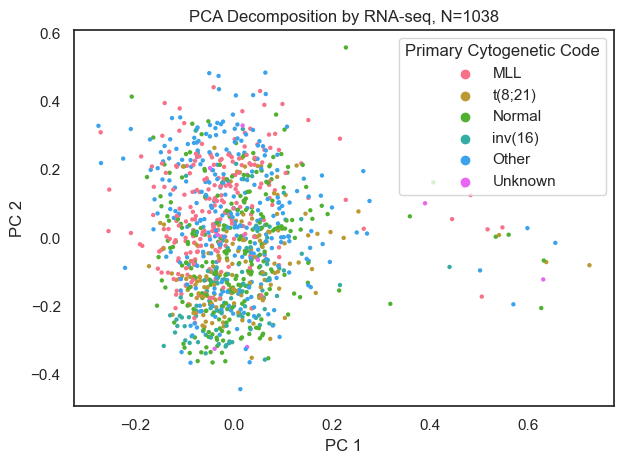

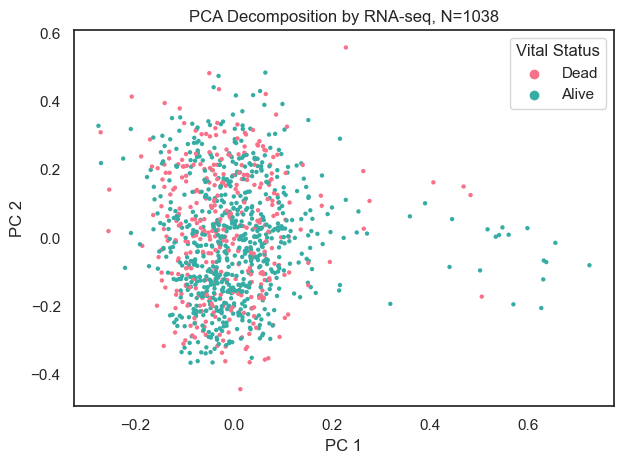

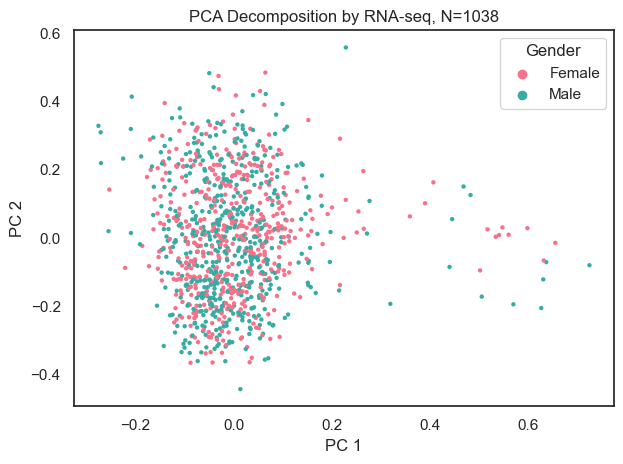

In [94]:
draw_PCAplot(data_PCs)
draw_PCAplot(data_PCs, hue="Primary Cytogenetic Code")
draw_PCAplot(data_PCs, hue="Vital Status")
draw_PCAplot(data_PCs, hue="Gender")

## UMAP

In [88]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, n_epochs=100, random_state=42)
mp_umap = reducer.fit_transform(log_scaled_data.T)

In [95]:
def draw_UMAPplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    # Define scatterplot

    sns.scatterplot(data=clinical, x=xs, y=ys,
                    palette='husl', s=10,
                    linewidth=0, alpha=1, hue=hue)

    # Define plot specs
    plt.title("UMAP by RNA-seq, N=1038",
               fontsize = 12)        
               
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()

    # Save figure
    if(hue):
        title = hue
        plt.savefig('../Plots/UMAP_by_' + title + '.png',
        bbox_inches='tight', dpi=300)
    else:
        plt.savefig('../Plots/UMAP.png',
        bbox_inches='tight', dpi=300)

    return(plt.show())

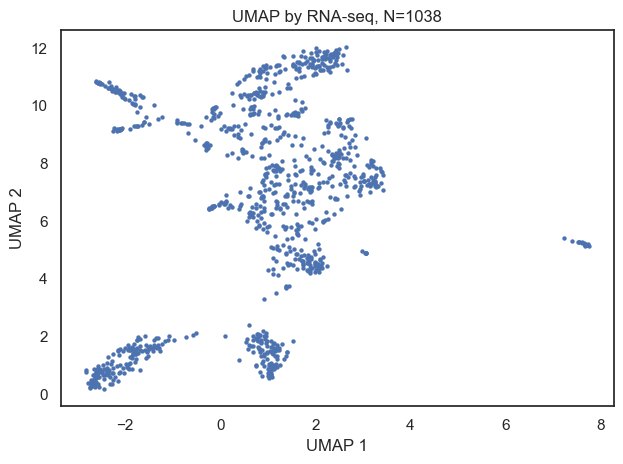

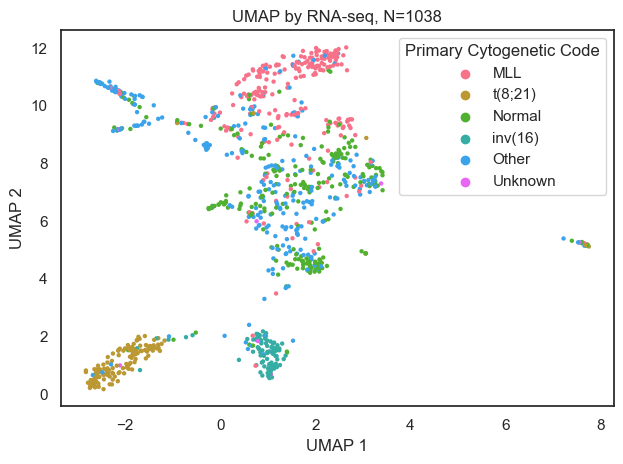

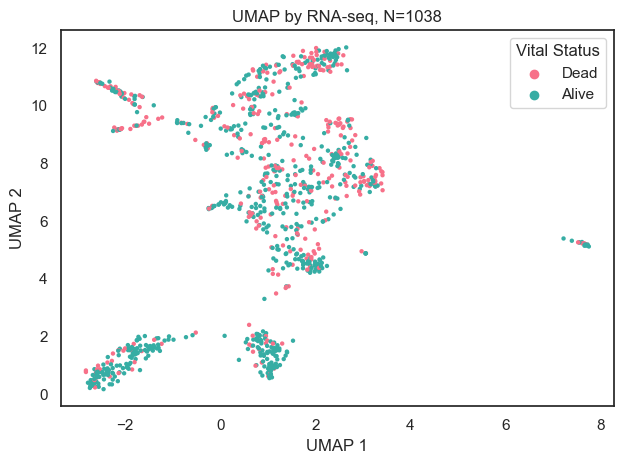

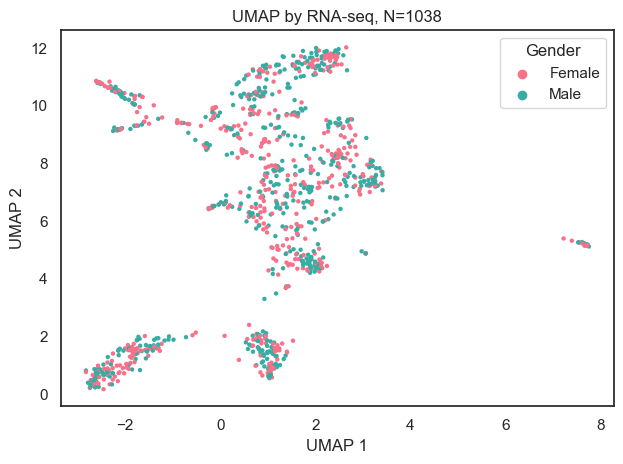

In [96]:
#Call the UMAP function.
draw_UMAPplot(mp_umap)
draw_UMAPplot(mp_umap, hue="Primary Cytogenetic Code")
draw_UMAPplot(mp_umap, hue="Vital Status")
draw_UMAPplot(mp_umap, hue="Gender")

## Preparing data for R

In [ ]:
# Read pickled data into data frame
counts = pd.read_pickle('../Data/raw_counts_data.pickle')
# Read data frame into .csv for exporting to R
counts.to_csv('../Data/raw_counts_data.csv', mode ='w+',index_label="Gene")
#Excluding the genes on the .pickle as well - 
counts.to_pickle('../Data/raw_counts_data.pickle')

# Same for clinical data
clinical = pd.read_pickle('../Data/clinical_data.pickle')
clinical.to_csv('../Data/clinical_data.csv')

## Heat Map
TO DO

In [ ]:
significant_genes = pd.read_csv('../Data/wrong_significant_genes.csv').rename(columns={"Unnamed: 0":"Genes"}).set_index("Genes") # From R
log_scaled_data = pd.read_pickle('../Data/log_scaled_data.pickle')
clinical = pd.read_pickle('../Data/clinical_data.pickle')

In [ ]:
log_scaled_data

# Sorting by Relapse

In [ ]:
clinical['First Event'].value_counts() # Censored: 0 / Relapse: 1 (Censored means patient dropped out of the study = Patient is likely healthy)

In [ ]:
clinical_sorted = clinical.sort_values(by=["Relapse"])
overall_sorted = clinical_sorted.join(log_scaled_data.T, how='inner')
clinical_sorted = overall_sorted.iloc[:,:66]
data_sorted = overall_sorted.iloc[:,67:]

# Sorting by Vital Status

In [ ]:
clinical_sorted = clinical.sort_values(by=["Vital Status"])
overall_sorted = clinical_sorted.join(log_scaled_data.T, how='inner')
clinical_sorted = overall_sorted.iloc[:,:66]
data_sorted = overall_sorted.iloc[:,67:]

In [ ]:
data_sorted

In [ ]:
clinical_sorted